# FYS9555 Project 2 «Cosmic Rays»

## Victor Ananyev

## 1. Cosmic rays

*Cosmic ray measurements.* The presence of an ionizing radiation at the Earth’s surface was already recognized by Coulomb in 1785. More than a century later, Hess showed conclusively that the ionisation rate increases with altitude, suggesting that it has a cosmic origin. By the 1930s, the observations of the geomagnetic latitude effect by Clay and coincidence measurements using two Geiger-Muller counters by Bothe and 
Kohlhörster demonstrated that this ionizing radiation consists mainly of charged particles, coined later “cosmic rays”.

In the 1940s, measurements using cloud  chambers  and  photographic  plates  carried  by  balloons  into  the  stratosphere  showed  that cosmic rays (CRs) consist mainly of relativistic protons, with an admixture of heavier nuclei. The  existence  of  extensive air showers triggered by high-energy  CRs  was  established  by Kohlhörster, Auger, and their collaborators in the 1930s.

After the second world war, large detector  arrays  were  installed  to  measure  these  extensive  air  showers,  establishing  a  power  law $\frac{dN}{dE} \propto \frac{1}{E^α}$. In the following years, the M.I.T. group deployed at the Volcano Ranch an array of scintillation counters covering an area of $12~km^2$ which recorded in 1962 an air shower with energy around $10^{20}~eV$.  At present, the two largest arrays observing CRs are the Pierre Auger Observatory (PAO) located in Argentina covering an area of $3000~km^2$ and the Telescope Array (TA) in the USA covering $900~km^2$.  Both are hybrid experiments combining surface detectors to measure air showers on the ground and fluorescence detectors which can follow the longitudinal development of the showers in the atmosphere.

A summary of CR intensity measurements is shown in the figure below. In such figures, the particle intensity $I(E)$ is often multiplied by a power $α$ of the energy $E$ such that $E^α I(E)$ becomes approximately flat, making thereby structures in $I(E)$ more visible.

<img src="img/overall.png" width="60%" />

In the flux of CR nuclei, which is the dominating contribution to the total CR flux, additional to the CR knee another break at $3×10^{18}~eV$ called the ankle and a cut-off like feature around $10^{20}~eV$ are visible.  Below $20~GeV$, the CR spectrum is suppressed because the magnetic field embedded within the Solar wind plasma prevents that charged low-energy particles enter the Solar system.

The second most-prominent species in the CR flux are electrons which flux is reduced by a factor of order 100 relative to the one of nuclei.  The fluxes of their antiparticles, antiprotons and positrons, are of comparable magnitude and suppressed by two orders of magnitude relative to electrons. 

Since the maximal area of a balloon or satellite experiment is of the order of a few square meter, the energy $10^{14}~eV$ marks the end of direct detection experiments. These experiments have typically the ability to measure the charge of individual CRs and thus the fluxes of individual CR nuclei are relatively well-known up to this energy. At higher energies, the CR flux drops to a level which prohibits to collect them with high enough statistics using detectors of few $m^2$ size.  However, at these energies, the extensive showers of secondary particles initiated by CR primaries interacting in the atmosphere start to reach the ground. Detecting Cherenkov and fluorescence light of such showers in the atmosphere, as well  as  the  secondary particles on the ground allows one to reconstruct the energy and arrival direction of the primary CR rather precisely.

The determination of the primary mass has been, however, a challenging problem for these indirect measurements, although considerable progress has been made in the last 15 years.

*Astrophysics of cosmic rays.* In 1934, Baade and Zwicky suggested presciently that CRs draw their energy from supernovae explosions. Hiltner and Hall discovered in 1949 an ubiquitous magnetic field in the Milky Way through the polarisation of star light. In the same year, Fermi proposed his theory of CR acceleration by moving “magnetic clouds”, explaining for the first time how a power-law like energy spectrum can arise through the combined action of accelerationand  losses. One  might  view  this  year  as  the  birth  date  of  the  “astrophysics  of  cosmic  rays”, i.e. the research field studying the acceleration and propagation of cosmic rays. Five years later, Morrison, Olbert, and Rossi suggested that the path length of CRs in the Milky Way should be small relative to their interaction lengths, leading to the application of realistic diffusion models to the propagation of Galactic CRs. This approach was worked out then in detail in the classic book of Ginzburg and Syrovatskii. Fermi’s idea of second-order acceleration was developed further into the theory of diffusive shock acceleration around 1977. In this theory, the energy gain per cycle is linear in the shock velocity, while it is quadratic in the cloud velocity in Fermi’s original model. Consequently, diffusive shock acceleration leads to much larger maximal energies for the same acceleration time.  Therefore it is today considered as the leading explanation for the acceleration of CRs in a large variety of astrophysical environments, ranging from shocks in the Solar corona, pulsar winds, and supernova remnants up to active galactic nuclei and gamma-ray bursts. A crucial prediction of diffusive shock acceleration is the slope of the energy spectra $\frac{dN}{dE} \propto \frac{1}{E^β}$ of accelerated particles

Two additional constraints on potential CR sources apply to their *age* and their *compactness*:

* If the source is too compact, the strong magnetic field leads to too large energy losses, reducing the allowed area for $10^{20}~eV$ proton sources to the light-grey area shownin the Hillas plot.

* In the opposite case of a very extended source with a weak magnetic field, the acceleration time may exceed the age of the source. In the specific case of CRs accelerated by SN shocks, the maximum energy was estimated by Lagage and Cesarsky as 10 TeV, assuming that the magnetic field is pependicular to the shock and its strength close to the shock equals the ambient magnetic field, $B \approx 3~μG$. This result would exclude shock acceleration in SNRs as source of Galactic CRs up to the knee.

Going beyond the test-particle approximation for shock acceleration leads to two modifications: 

* First, the pressure of CRs modifies the shock profile, and as a result the CR spectra deviate from a simple power law and become concave.

* Second, and more importantly, the escape current of CRs leads to an efficient magnetic field amplification via the Bell instability, increasing thereby the possible maximal energies of CRs.

The theoretical suggestion of magnetic field amplification is supported by various observations: For instance, the analysis of the morphology of X-ray emissionclose to the outer shocks of SN1006 and Cas-A imply  that strong magnetic fields on the order of $100~μG$ are  needed  to  explain rapid synchrotron losses by high-energy  electrons.

The presence of stronger magnetic fields close to shocks re-opens the possibility that supernovae accelerate CRs up to the knee and beyond. Cosmic rays interacting with  gas or background  photons  produce  neutral and charged pions whose decays in turn lead to secondary high-energy photons and neutrinos. The combined study of potential CR sources using charged CRs together with photons and neutrinos has developed into the field of *multi-messenger astronomy*.  Moreover, there is a close relationship with searches for gravitational waves:  Many suggested CR sources tap their energy from the gravitational collapse of a compact object, which leads to the emission of gravitational waves. Vice versa it is expected that the merger of a binary system involving one or two neutron stars leads to the acceleration of high-energy particles, as it was observed for the first time in the case of GW170817: This event was observed extensively in the optical,  x-ray and gamma-ray part of the electromagnetic spectrum, with a spectrum characteristic for a short gamma-ray burst.

*Based on* https://arxiv.org/abs/1904.08160 . *Find more references in the text of the introduction there*

## 2. The POLA detectors

The scientific intent of the PolarquEEEst experiment is to measure the rate of cosmic rays at the sea level in a wide latitude range, expecially in the artic region where few measurements are available. Due to the shape of the Earth’s magnetic field in the artic regions, an increase of the cosmic ray flux with respect to low-latitude regions is expected. Moreover, starting from about 60°N another effect due to the solar wind is expected to produce a saturation on the flux, flattening the rate. Experimental measurements have been summarised by A. H. Compton in 1933 that confirm these  expectations. Figure below shows the  plot  made  by Compton of the intensity of the cosmic radiation at the sea level as a function of the latitude.

<img src="img/compton-lat.png" width="60%" />

*The PolarquEEEst detectors and experimental setup.* 

Each of the “POLA” detectors is made of:

* two floors of four tiles of **plastic scintillator** ($20×30×1~cm$ 3B400 Saint-Gobain), $11~cm$ apart in the vertical axis as shown in the figure

* the light-sensitive part of the device is enclosed with a **light-tight plastic box**.

* a pair of **silicon photomultipliers (SiPM)** is attached to each of the scintillator tiles and optically coupled by means of an optical gel in the positions highlighted in the figure (c)

The light produced by the passage of a charged particle through the scintillator is converted by SiPMs to an electric signal.

* eight **front-end boards**, each capable of handling two different SiPMs signals separately, are dedicated to discriminate this analogue signal (only signals above a certain configurable threshold are selected)

* the **trigger** and **read-out board (TRB)** is used to measure the time-over-threshold (ToT) of the signals discriminated by the front-end boards.

* the TRB is equipped with an Altera Cyclone 5 **FPGA**, workingat 100 MHz speed, that implements in firmware:

    * 16 time-to-digital converters (TDC)
    * the trigger logic and a high-resolution timer to put a time stamp to the detected events with a $10 ns$ resolution

* the trigger and read-out board is also provided with a u-blox EVK-M8GZOE-0 **GPS/GLONASS receiver** that allows:
    * the positioning and the time synchronisation of the POLA detectors
    * sensors for continuously monitor the tilt in the three axes (3D gyroscope)
    * monitor the heading (3D compass)
    * monitor the temperature inside the scintillator and the electronic boxes and outside the detector separately
    * monitor the atmospheric pressure and humidity

* Along with the FPGA TDCs, an **HPTDC board**, mounted on a mezzanine of the TRB, is devotedto the digitisation of front-end discriminated signals for redundance and cross check
* **Raspberry Pi 3** model B+ for data acquisition and transfer. 

<img src="img/pola-struct.png" width="60%" />

The trigger condition is set by the coincindence within $10~ns$ of the signal from the pair of SiPMs of one tile, in the same coincidence window with a signal of any other SiPM on the other plane. A triggered event contains all the SiPM hits within the trigger window and contains their ToTs and the time information of the first triggered hit.

The data acquisition and storage to file (DAQ) are performed by a Python script running on a Raspberry Pi 3 model B+ which is connected to the TRB via a serial connection. Another Python script, the PolarquEEEst DAQ Control and Monitor, allows to control and monitor the DAQ system through a web-based user interface written in HTML5 and JavaScript. The acquired data are continuously sent via Internet to the INFN-CNAF computing centre, located in Bologna, Italy, for permanent storage, analysis and monitor. During the PolarQuest 2018 mission, the acquired data files were stored on the microSD card of the Raspberry Pi because the $10~W$ limited power budget available on the boat prevented the use of a more robust, yet power hungry, storage solution. For the current phase, PolarquEEEst 2019, a $2~TB$ external hard drive has been attached to each of the POLA detectors to extend the buffer of local data in case of possible Internet connection black-outs.

*Based on conference proceedings:* https://pos.sissa.it/358/371/pdf

## 3. Data analysis

In [116]:
import itertools
import os

from collections import defaultdict

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import statsmodels.formula.api as smfa

plt.rcParams["figure.figsize"] = (12,8)

In [2]:
DATA_DIR = "data"

In [3]:
CORRUPTED_TRENDING_COLS = set(['RateTrackEventsTheta0_10',
                               'RateTrackEventsTheta10_20',
                               'RateTrackEventsTheta20_30',
                               'RateTrackEventsTheta30_40',
                               'RateTrackEventsTheta40_50',
                               'RateTrackEventsTheta50_60',
                               'RateTrackEventsTheta60_90',
                               'AvTOTBot', 'AvTOTMid', 'AvTOTTop'])

Read the data into dataframes. For `Trending` we noticed that some files miss columns `CORRUPTED_TRENDING_COLS`. We decided to normalize all the data, and drop these columns from everywhere (since we don't plan to use them in the project anyways). At the same time we collect copies of corrupted data in the separate dataframe for future investigations

In [4]:
def struct_files(files):
    header = None
    weather = None
    trending = None
    for f in files:
        if not f.endswith(".csv"):
            continue
        if "Header" in f:
            header = f
        elif "Weather" in f:
            weather = f
        elif "Trending" in f:
            trending = f
    return header, weather, trending

In [5]:
def assemble_cuts(df, cut_list):
    res = []
    for cut_name in cut_list:
        cut = CUTS
        for path_part in cut_name.split("."):
            cut = cut[path_part]
        res.append(cut(df))
    return np.any(res, axis=0)

In [86]:
# which lines to drop

CUTS = {
    "runs": {
        "small_event_number": lambda df: df["NumEvents"] < 12000,
        "run_time_too_long": lambda df: ((df["RunStop"] - df["RunStart"]) > 1000000),
        "run_time_too_short": lambda df: ((df["RunStop"] - df["RunStart"]) < 60*10),
        "pola3_perturb_time": lambda df:   (df["RunNumber"] < 3661E5) \
                                         & (df["RunNumber"] > 3654E5) \
                                         & (df["telescope"] == "POLA-03"),
        "pola1_time_misses": lambda df:   (df["RunNumber"] < 3663E5) \
                                         & (df["RunNumber"] > 3655E5) \
                                         & (df["telescope"] == "POLA-01"),
    }
}

In [7]:
def parse_header(path, tid):
    read_h = pd.read_csv(path, header=0).rename(columns={"#RunNumber": "RunNumber"})
    read_h["telescope"] = pd.Series(np.full_like(read_h["telescope"], tid))
    return read_h

In [8]:
def parse_weather(path):
    read_w = pd.read_csv(path, header=0).rename(columns={"#Seconds": "Seconds"})
    return read_w

In [9]:
def parse_events(path, runs):
    read_t = pd.read_csv(path, header=0).rename(columns={"#BinStart": "BinStart"})
    
    corrupted = CORRUPTED_TRENDING_COLS - set(read_t.columns)
    cols_to_drop = set(read_t.columns) & CORRUPTED_TRENDING_COLS
    read_t.drop(columns=cols_to_drop, inplace=True)
    read_t = pd.merge(runs[["telescope", "UniqueRunId"]], read_t, on="UniqueRunId", how="left")
    
    return read_t, corrupted

In [10]:
class CorruptedRecordException(Exception):
    pass

In [11]:
def parse_runs(header_f, weather_f, resource):
    header_d = parse_header(header_f, resource)
    if header_d.shape[0] == 0:
        raise CorruptedRecordException(f"Corrupted header: {h}")

    weather_d = parse_weather(weather_f)
    if weather_d.shape[0] == 0:
        raise CorruptedRecordException(f"Corrupted weather: {w}")

    runs = pd.merge(header_d, weather_d, on="UniqueRunId", how="left", validate="one_to_one")

    header_missing_weather = np.count_nonzero(~np.isin(header_d["UniqueRunId"], weather_d["UniqueRunId"]))
    if header_missing_weather:
        print(f"Header missing Weather: {header_missing_weather}. {header_f.split('/')[-1]}")

    run_cuts = assemble_cuts(runs, ["runs.small_event_number", 
                                    "runs.run_time_too_long",
                                    "runs.run_time_too_short"])
    
    return runs[~run_cuts]

In [12]:
data_map = {"Runs": [], "Events": []}


for resource in ["POLA-01", "POLA-02", "POLA-03"]:
    for root, dirs, files in os.walk(os.path.join(DATA_DIR, resource)):
        if not files:
            continue
        if len(files) != 3:
            print(f"Suspicious data in {root}")
        h, w, t = struct_files(files)
        
        try:
            runs = parse_runs(os.path.join(root, h),
                              os.path.join(root, w),
                              resource)
            data_map["Runs"].append(runs)
        except CorruptedRecordException as e:
            print(e)
            continue
        
        events, events_corrupted = parse_events(os.path.join(root, t), runs)
        data_map["Events"].append(events)
        if events_corrupted:
            print(f"Corrupted events: ts {events['BinStart'].iloc[0]} - {events['BinEnd'].iloc[-1]}. {root}/{t}")
            
        events_without_header = np.count_nonzero(~events["UniqueRunId"].isin(runs["UniqueRunId"]))
        if events_without_header:
            print(f"There are events without header: {events_without_header}. {root}/{t}")

Corrupted events: ts 364521650.0 - 364607881.0. data/POLA-01/2018-07-21/POLA-01_2018-07-21_2018-07-21_summary_Trending.csv
Corrupted events: ts 364694646.0 - 364852038.0. data/POLA-02/2018-07-24/POLA-02_2018-07-23_2018-07-24_summary_Trending.csv
Corrupted events: ts 364522419.0 - 364608495.0. data/POLA-02/2018-07-21/POLA-02_2018-07-21_2018-07-21_summary_Trending.csv
Corrupted events: ts 364954724.0 - 365116627.0. data/POLA-02/2018-07-27/POLA-02_2018-07-26_2018-07-27_summary_Trending.csv
Corrupted events: ts 364781126.0 - 364934932.0. data/POLA-02/2018-07-25/POLA-02_2018-07-24_2018-07-25_summary_Trending.csv
Corrupted events: ts 364608549.0 - 364694595.0. data/POLA-02/2018-07-22/POLA-02_2018-07-22_2018-07-22_summary_Trending.csv
Corrupted events: ts 364694646.0 - 364781077.0. data/POLA-02/2018-07-23/POLA-02_2018-07-23_2018-07-23_summary_Trending.csv
Corrupted events: ts 364867798.0 - 365031132.0. data/POLA-02/2018-07-26/POLA-02_2018-07-25_2018-07-26_summary_Trending.csv
Corrupted events

In [13]:
runs = pd.concat(data_map["Runs"]).sort_values("RunNumber", axis="index").reset_index(drop=True)
events = pd.concat(data_map["Events"]).sort_values(["UniqueRunId", "BinStart"], axis="index").reset_index(drop=True)

Quality checks and alignment checks for `Header` and `Weather` timestamps. It turns out that there are 49 of ~13500 rows that are missaligned by 1 or 2 seconds. Good thing to be aware of.

In [14]:
# total number of events
print("Runs: ", runs.shape[0])

# how many runs for tracking do we have?
print("Runs for tracking: ", np.unique(events["UniqueRunId"]).shape)

# test RunDuration consistency
assert np.all(np.isclose(runs["RunStop"] - runs["RunStart"], runs["RunDuration"]))

# how many timestamp misalignments are there?
mask = (runs["RunNumber"] != runs["Seconds"])
(runs[mask]["Seconds"] - runs[mask]["RunNumber"]).describe()

Runs:  13036
Runs for tracking:  (8120,)


count    46.000000
mean      1.021739
std       0.147442
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
dtype: float64

`RunNumber` (form header) is almost the same as `Seconds` (from weather), and apparently means a moment of measuring the weather for specific run. `RunStart` is an exact time of run start. We see that there was a region between 365.5-366.5 MegaSeconds($10^6 s \approx 10~days$), where we've got weather measures delayed (why?). If converted to real world dates, the timerange of the artifact corresponds to 1-10 Aug 2018.

We also have some dramatic misses in temperature measures for few points. For this runs, weather was measured ~30s in advance before actual run

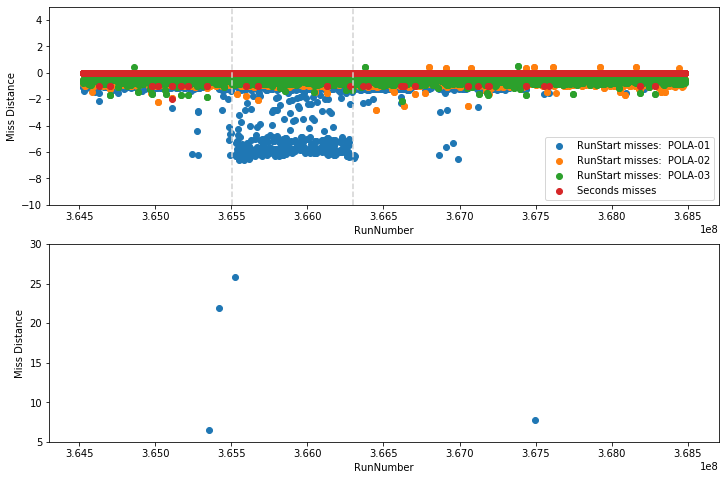

In [90]:
def plot_misses(axes, runs):
    ax = axes[0]
    runs.groupby("telescope", group_keys=True).apply(lambda tsc: \
        ax.scatter(tsc["RunNumber"], tsc["RunNumber"]-tsc["RunStart"], label=f"RunStart misses:  {tsc['telescope'].iloc[0]}")
    )
    ax.scatter(runs["RunNumber"], runs["RunNumber"]-runs["Seconds"], label=f"Seconds misses")
    ax.legend()
    ax.set_xlabel("RunNumber")
    ax.set_ylabel("Miss Distance")
    ax.set_ylim([-10, 5]);
    
    misses = runs[assemble_cuts(runs, ["runs.pola1_time_misses"])]
    ax.axvline(misses.iloc[0]["RunNumber"], ls="--", color="lightgray")
    ax.axvline(misses.iloc[-1]["RunNumber"], ls="--", color="lightgray")
    
    ax = axes[1]
    runs.groupby("telescope", group_keys=True).apply(lambda tsc: \
        ax.scatter(tsc["RunNumber"], tsc["RunNumber"]-tsc["RunStart"], label=f"RunStart misses:  {tsc['telescope'].iloc[0]}")
    )
    ax.set_xlabel("RunNumber")
    ax.set_ylabel("Miss Distance")
    ax.set_ylim([5, 30]);

fig, ax = plt.subplots(2)
plot_misses(ax, runs)

In [ ]:
def binned_agg(df, xlabel, ylabel, agg, binsize, groups="telescope", agg_err=None):
    if agg_err is None:
        def error_func(x):
            return np.sqrt(np.mean((x - agg(x))**2))
    else:
        def error_func(x):
            return agg_err(x)
    def agg_func(x):
        # pandas is buggy with lambdas, they are unnamed :(
        return agg(x)
    
    def process_group(group_df):
        bins = np.arange(df[xlabel].values.min(), df[xlabel].values.max() + binsize/2, binsize)
        return group_df.set_index(xlabel)[[ylabel]] \
            .groupby(lambda idx: bins[np.searchsorted(bins, idx, side="right") - 1]) \
            .agg(**{
                ylabel: (ylabel, agg_func),
                f"{ylabel}_err": (ylabel, error_func)
            }).rename_axis(index={None: xlabel})
    
    if groups is not None:
        means = df.groupby(groups).apply(process_group)
    else:
        means = process_group(df)
        
    return means

In [17]:
np.percentile(events[events["telescope"] == "POLA-03"]["BinStart"].iloc[1:].values - events[events["telescope"] == "POLA-03"]["BinStart"].iloc[:-1].values, 99)

90.0

### 3.1 Environmental conditions

Here we show plots for IndoorTemperature, OutdoorTemperature and Pressure depending on time and a telescope. From the plots we can see that, as expected, `POLA-01` has very variable measures because it is drifting through the ocean.

What is also interesting, is that the artifact we saw in `RunStart misses` plot above (for POLA-01) was happening close to the time region we see here, but for POLA-03. Mystery.


In [18]:
binned_agg(events, "BinStart", "IndoorTemperature", np.mean, 60*10).groupby("telescope").describe()

IndoorTemperature                                           \
                      count       mean       std       min       25%   
telescope                                                              
POLA-01              5161.0  25.356046  2.789492  17.34211  23.40022   
POLA-02              6453.0  25.058713  0.135105  24.64132  24.96511   
POLA-03              6455.0  33.355453  0.842570  29.09589  33.04969   

                                          IndoorTemperature_err            \
                 50%        75%       max                 count      mean   
telescope                                                                   
POLA-01    25.171057  27.370610  32.47807                5161.0  0.049289   
POLA-02    25.060340  25.155570  25.49840                6453.0  0.018011   
POLA-03    33.591930  33.846729  36.75874                6455.0  0.037423   

                                                                 
                std  min  25%           50%       75%       max  
telescope                                                        
POLA-01    0.119338  0.0  0.0  0.000000e+00  0.029824  1.407898  
POLA-02    0.031326  0.0  0.0  3.552714e-15  0.027993  0.217674  
POLA-03    0.091127  0.0  0.0  7.105427e-15  0.037084  1.180435

In [19]:
def plot_weather(ax, col, binsize):
    binned_agg(events, "BinStart", col, np.mean, binsize) \
        .groupby(level=0) \
        .apply(lambda tsc: \
            ax.errorbar(x=tsc.index.get_level_values(1),
                        y=tsc[col],
                        yerr=tsc[f"{col}_err"],
                        label=tsc.index.get_level_values(0)[0],
                        fmt=".")
        )
    ax.legend()
    ax.set_ylabel(col);
    ax.set_xlabel(f"BinStart, binsize={binsize}");
    ax.axvline(runs[assemble_cuts(runs, ["runs.pola3_perturb_time"])]["Seconds"].values[0], ls="--", color="lightgray")
    ax.axvline(runs[assemble_cuts(runs, ["runs.pola3_perturb_time"])]["Seconds"].values[-1], ls="--", color="lightgray")

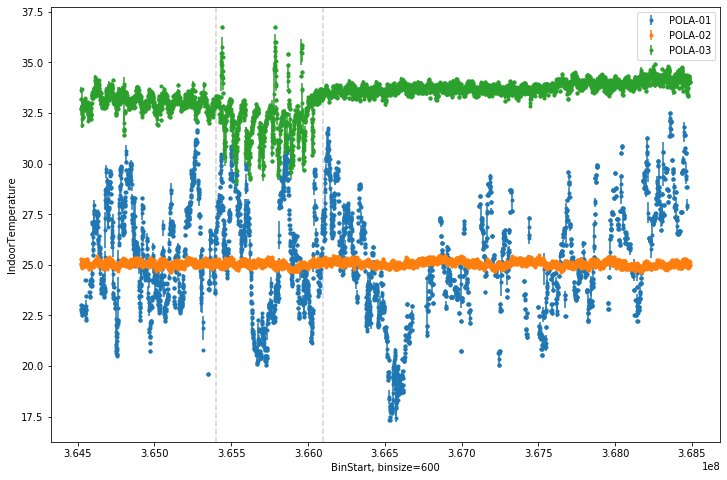

In [20]:
fig, ax = plt.subplots()
plot_weather(ax, "IndoorTemperature", 600)

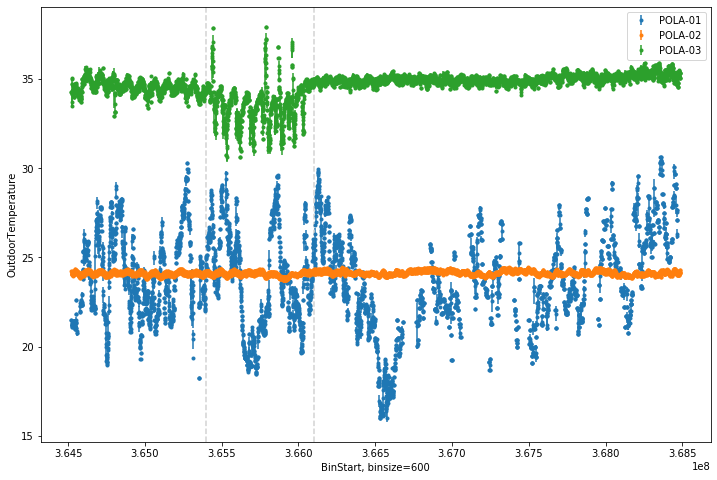

In [21]:
fig, ax = plt.subplots()
plot_weather(ax, "OutdoorTemperature", 600)

We also notice that POLA-03 has better cooling system, `IndoorTemperature` is significantly lower than `OutdoorTemperature` for POLA-03. For other telescopes difference is not that explicit.

Finally, pressure plots show that while pressure conditions are quite similar for POLA-01 and POLA-02, since POLA-03 is located 250m heigher, POLA-03 shows significant pressure drop. That's why in the following steps, to conduct a collective study of data from all the telescopes, we'll have to introduce barometric correction.

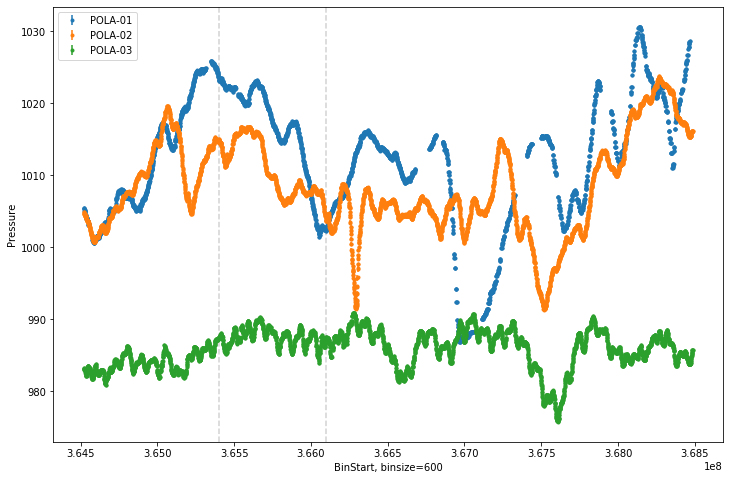

In [22]:
fig, ax = plt.subplots()
plot_weather(ax, "Pressure", 600)

### 3.2 Particle raw rate

In [23]:
runs.groupby("telescope").apply(lambda x: (x["RunDuration"]).describe())

RunDuration,count,mean,std,min,25%,50%,75%,max
telescope,,,,,,,,
POLA-01,2144.0,1375.945432,339.154096,611.045794,1192.727826,1211.364285,1262.869318,2150.878952
POLA-02,5778.0,1188.159916,59.175409,600.270483,1186.452713,1195.715225,1206.518553,1323.544574
POLA-03,5114.0,1353.008754,68.360951,617.554274,1354.545375,1361.137087,1367.289846,1577.140166


As we can see from the RunDuration distribution descriptive statistics, running times might vary from 10 to 20 minutes. It means, that at the timescale of 12h it is acceptable to neglect overlaps over timebins, and assign to one bin those events which has their `RunStart` within the bin, and not care much about `RunStop`. 

In [24]:
avg_rate_color_map = {"POLA-02": plt.get_cmap("tab10")(1),
                      "POLA-03": plt.get_cmap("tab10")(2),
                      "POLA-01": plt.get_cmap("tab10")(0)}

In [25]:
def pivot_on_binned_time(df, xlabel, xagg, xagg_err, binsize, on="RunStart", ylabel="NumEvents", yagg=None, yagg_err=None):
    if yagg is None:
        yagg = lambda x: np.sum(x)/binsize
    if yagg_err is None:
        yagg_err = lambda x: np.sqrt(x.sum())/binsize
    binned_numevents = binned_agg(df, on, ylabel, yagg, binsize, agg_err=yagg_err) \
    
    newx = binned_agg(df, on, xlabel, xagg, binsize, agg_err=xagg_err).reset_index(drop=False)
    return binned_numevents\
                .reset_index(drop=False) \
                .merge(newx, on=["telescope", on]) \
                .drop(columns=[on]) \
                .groupby("telescope") \
                .apply(lambda df: df.sort_values(["telescope", xlabel], axis=0)) \
                .set_index(["telescope"])

In [26]:
def show_sorted_legend(ax):
    if not isinstance(ax, list):
        ax = [ax]
    ax_iter = iter(ax)
    for a in ax_iter:
        a.legend(*zip(*sorted(zip(*a.get_legend_handles_labels()), key=lambda t: t[1])))

In [29]:
def plot_bars_from_pivot(ax, pivot, xlabel, ylabel, xscale=1):
    if not isinstance(ax, list):
        ax = itertools.repeat(ax)
    ax_iter = iter(ax)
    
    for tsc, tsc_color in avg_rate_color_map.items():
        ts = pivot.loc[tsc]
        xs = ts[xlabel].values/xscale
        widths = xs[1:] - xs[:-1]
        widths = np.hstack([widths, [np.median(widths)]])
        next(ax_iter).bar(xs,
                          ts[ylabel].values,
                          width=widths,
                          alpha=0.8,
                          align="edge",
                          capsize=2,
                          yerr=ts[f"{ylabel}_err"].values,
                          color=tsc_color,
                          label=tsc)

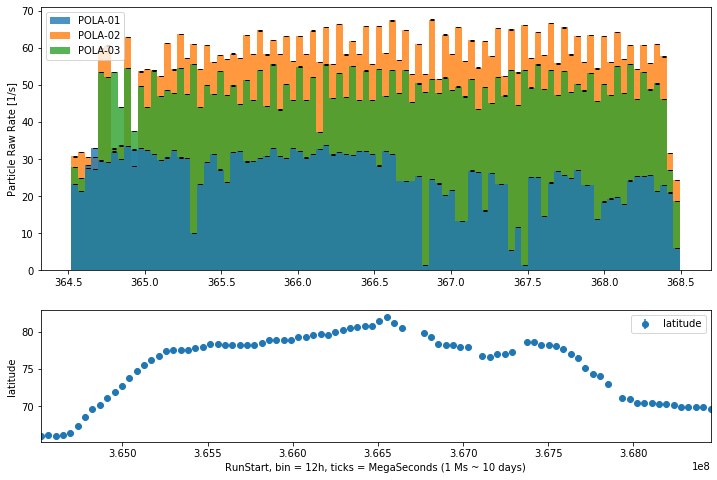

In [30]:
fig, ax = plt.subplots(2,  gridspec_kw={'height_ratios': [2., 1]})
plot_bars_from_pivot(ax[0],
                     binned_agg(runs, "RunStart", "NumEvents", lambda x: np.sum(x)/(60*60*12), 60*60*12, agg_err=lambda x: np.sqrt(x.sum())/(60*60*12)).reset_index(level=1, drop=False),
                     "RunStart",
                     "NumEvents",
                     xscale=1E6)
show_sorted_legend(ax[0])
ax[0].set_ylabel("Particle Raw Rate [1/s]");
binned_agg(runs, "RunStart", "latitude", np.mean, 60*60*12).loc["POLA-01"].plot(y="latitude", yerr="latitude_err", ls="none", marker="o", ax=ax[1])
ax[1].legend()
ax[1].set_xlabel("RunStart, bin = 12h, ticks = MegaSeconds (1 Ms ~ 10 days)");
ax[1].set_ylabel("latitude");

### 3.2.1 Longitude and latitude

In [31]:
def plot_scatter_from_pivot(ax, pivot, xlabel, ylabel, xscale=1.):
    if not isinstance(ax, list):
        ax = itertools.repeat(ax)
    ax_iter = iter(ax)
    for tsc, tsc_color in avg_rate_color_map.items():
        ts = pivot.loc[tsc]
        next(ax_iter).errorbar(ts[xlabel]/xscale,
                               ts[ylabel].values,
                               yerr=ts[f"{ylabel}_err"].values,
                               xerr=ts[f"{xlabel}_err"].values,
                               fmt="o",
                               capsize=2,
                               color=tsc_color,
                               label=tsc)

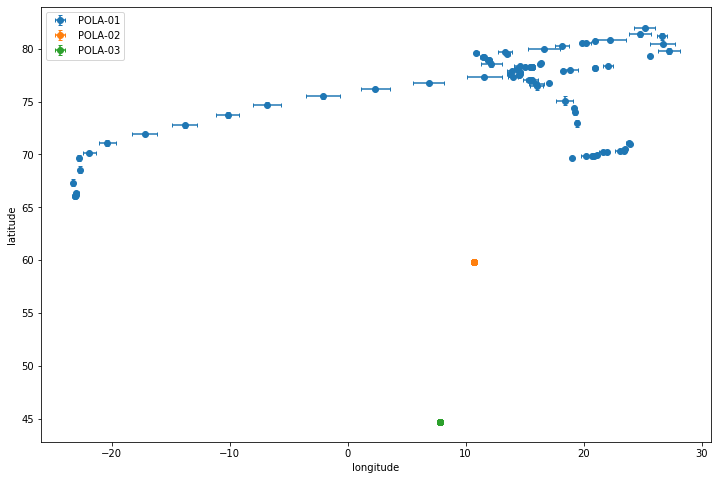

In [32]:
fig, ax = plt.subplots()
plot_scatter_from_pivot(ax,
                        pivot_on_binned_time(runs, "longitude", np.mean, np.std, 60*60*12, on="Seconds", ylabel="latitude", yagg=np.mean, yagg_err=np.std),
                        "longitude",
                        "latitude")
show_sorted_legend(ax)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude");

### Pressure and temperature

We apply cut here, since dependency on time is not explicit, and noisy perturbation can't be eliminated by eye

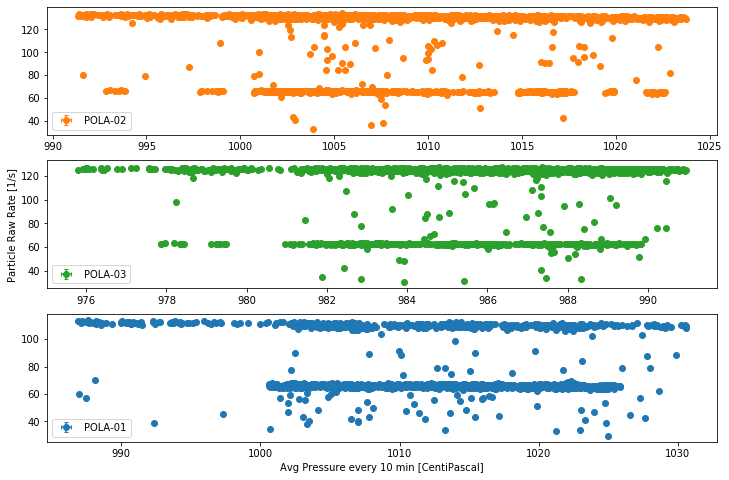

In [33]:
fig, ax = plt.subplots(3)
plot_scatter_from_pivot(list(ax),
                        pivot_on_binned_time(runs, "Pressure", np.mean, None, 60*10),
                        "Pressure",
                        "NumEvents",
                        xscale=1.)
show_sorted_legend(list(ax))
ax[2].set_xlabel("Avg Pressure every 10 min [CentiPascal]");
ax[1].set_ylabel("Particle Raw Rate [1/s]");

In [73]:
def binned_raw_rate(df, xlabel, binsize):
    duration = binned_agg(df, xlabel, "RunDuration", np.sum, binsize).reset_index(drop=False)
    tot_events = binned_agg(df, xlabel, "NumEvents", np.sum, binsize, agg_err=lambda x: np.sqrt(x.sum())).reset_index(drop=False)
    merged = pd.merge(duration, tot_events, on=["telescope", xlabel])
    merged["NumEvents"] = merged["NumEvents"]/merged["RunDuration"]
    merged["NumEvents_err"] = merged["NumEvents_err"]/merged["RunDuration"]
    merged.drop(columns=["RunDuration", "RunDuration_err"], inplace=True)
    return merged.set_index(["telescope", xlabel])

In [392]:
def plot_binned_raw_rate(ax, binned_raw_rate):
    binsizes = []
    for tsc, tsdf in binned_raw_rate.groupby(level=0, as_index=False):
        xs = tsdf.loc[tsc].index.values
        if xs.shape[0] > 1:
            binsize = np.median(xs[1:] - xs[:-1])
        elif binsizes:
            binsize = np.median(binsizes)
        else:
            binsize = 1.
        binsizes.append(binsize)
        ax.bar(xs, tsdf["NumEvents"], binsize, label=tsc, yerr=tsdf["NumEvents_err"], capsize=3, ecolor=np.array(avg_rate_color_map[tsc])*0.8, alpha=0.85, align="edge")
    ax.legend()
    ax.set_xlabel(f"{binned_raw_rate.index.names[1]}, binsize={np.mean(binsizes)}")
    ax.set_ylabel("RawRate [1/s]")

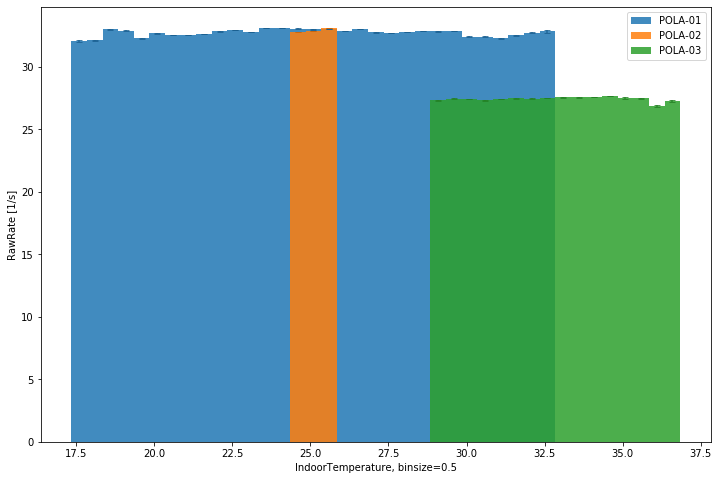

In [368]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs, "IndoorTemperature", 0.5))

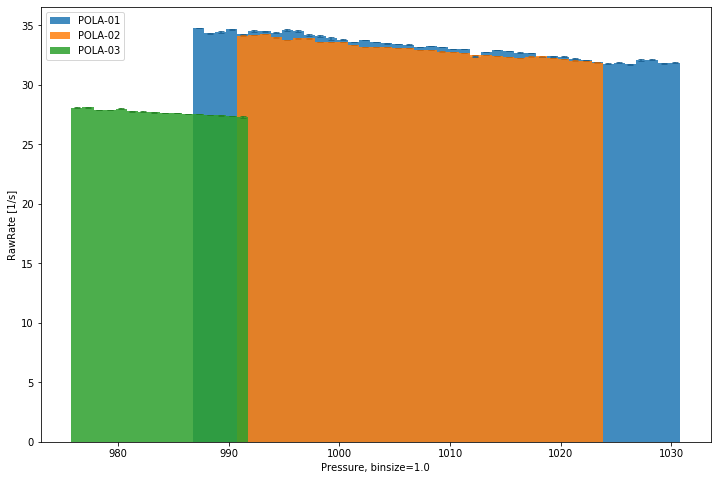

In [369]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs[~assemble_cuts(runs, ["runs.pola3_perturb_time"])], "Pressure", 1))

In [370]:
REFERENCE_PRESSURE = {
    "POLA-01": 1011.85,
    "POLA-02": 1008.53,
    "POLA-03": 985.87
}

In [382]:
ROOFTOP_CORRECTION = {
    "POLA-01": 1.,
    "POLA-02": 1.03,
    "POLA-03": 1.3
}

In [436]:
def rooftop_correct_runs(runs):
    res = []
    for tsc, df in runs.groupby("telescope"):
        df.loc[:, ["NumEvents"]] = df["NumEvents"].copy()*ROOFTOP_CORRECTION[tsc]
        res.append(df)
    return pd.concat(res)

In [467]:
def expfit_pressure(runs):
    res = []
    for tsc, tscdf in binned_raw_rate(runs, "Pressure", 1.).groupby(level=0):
        tscdf.reset_index(inplace=True)
        model = smfa.wls("log_NumEvents ~ Pressure_from_ref", data=tscdf.assign(log_NumEvents=np.log(tscdf["NumEvents"])) \
                                                               .assign(Pressure_from_ref=tscdf["Pressure"] - REFERENCE_PRESSURE[tsc]),
                         weights=tscdf["NumEvents"]/tscdf["NumEvents_err"]).fit()
        res.append((tsc, model))
    return res

def expfit_summary(expfit_models, sigmas):
    res = {}
    for tsc, model in expfit_models:
        cf = model.conf_int(1. - sp.stats.norm.cdf(sigmas))
        for param in model.params.index.values:
            res.update({(param, tsc): {"mean": model.params.loc[param],
                                       "ci_low": cf.loc[param][0],
                                       "ci_up": cf.loc[param][1],
                                       "t": model.tvalues.loc[param],
                                       "pval": model.pvalues.loc[param]}})
    return pd.DataFrame(res).T.sort_index(level=0)

def plot_conf_data(ax, summary):
    colors = np.vstack([avg_rate_color_map[tsc] for tsc in tscs])
    ax.errorbar(tscs, y=summary["mean"], yerr=[summary["mean"] - summary["ci_low"], summary["ci_up"] - summary["mean"]], capsize=5, zorder=0, color="black", fmt="none", marker="none", ls="none")
    ax.scatter(tscs, y=summary["mean"], marker="o", color=colors)

def show_expfit_analysis(ax, summary):
    display(summary)
    for idx, (field, df) in enumerate(summary.groupby(level=0)):
        plot_conf_data(ax[idx], df)
        ax[idx].set_ylim()
        ax[idx].set_ylabel(field)

In [483]:
runs_with_cuts = runs[
                        ~assemble_cuts(runs, ["runs.pola3_perturb_time",
                                              "runs.pola1_time_misses"])
                     ]

In [484]:
rooftop_correct_with_cuts = rooftop_correct_runs(runs_with_cuts)

mean    ci_low     ci_up             t  \
Intercept         POLA-01  3.493462  3.487998  3.498925   3899.637094   
                  POLA-02  3.521518  3.518259  3.524778   7038.290548   
                  POLA-03  3.578700  3.575607  3.581792  10558.990128   
Pressure_from_ref POLA-01 -0.002227 -0.002722 -0.001732    -27.427180   
                  POLA-02 -0.002175 -0.002581 -0.001769    -34.903674   
                  POLA-03 -0.001714 -0.002516 -0.000912    -19.508605   

                                    pval  
Intercept         POLA-01  2.253850e-118  
                  POLA-02   9.939778e-98  
                  POLA-03   1.031122e-49  
Pressure_from_ref POLA-01   1.941376e-28  
                  POLA-02   1.887261e-26  
                  POLA-03   1.506209e-11

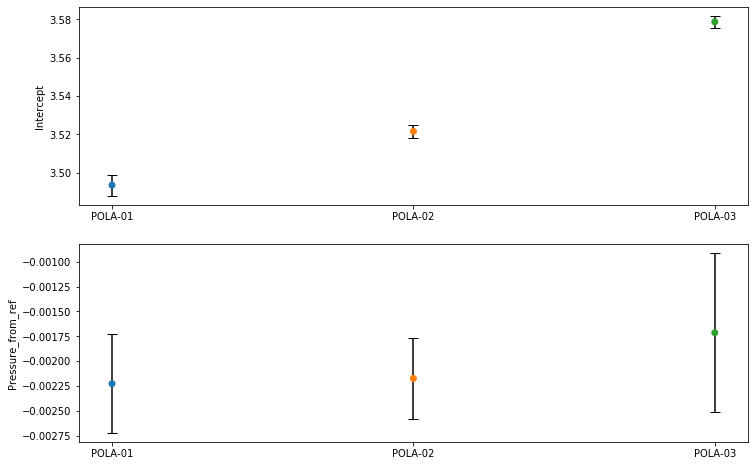

In [485]:
pressure_expfit_summary = expfit_summary(expfit_pressure(rooftop_correct_with_cuts), sigmas=5.)
fig, ax = plt.subplots(2)
show_expfit_analysis(ax, pressure_expfit_summary)

In [493]:
def correct_num_events_for_pressure(runs, fit_summary):
    res = []
    #intercept = fit_summary.loc["Intercept", tsc]["mean"]
    pressure_coef = fit_summary.loc["Pressure_from_ref", "POLA-02"]["mean"]
    ref_pressure = REFERENCE_PRESSURE[tsc]
    df = runs.copy()
    df.loc[:, ["NumEvents"]] = df["NumEvents"].copy()/(np.exp(
        (df["Pressure"].copy() - ref_pressure) * pressure_coef
    ))
    return df

In [494]:
runs_corrected_pressure = correct_num_events_for_pressure(rooftop_correct_with_cuts, pressure_expfit_summary)

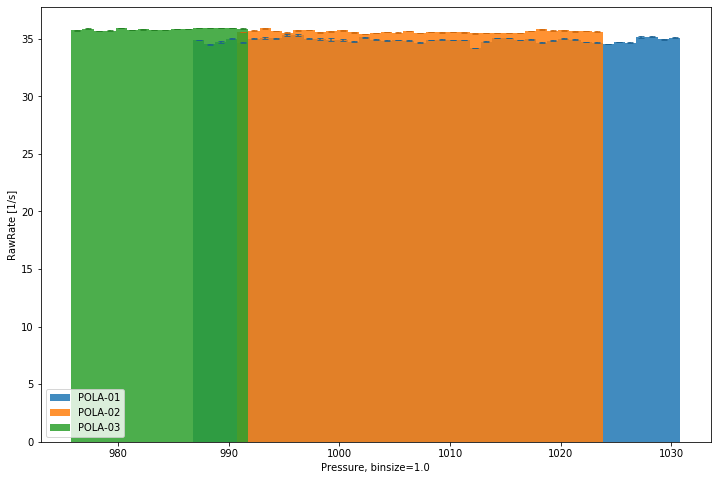

In [495]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs_corrected_pressure, "Pressure", 1.))

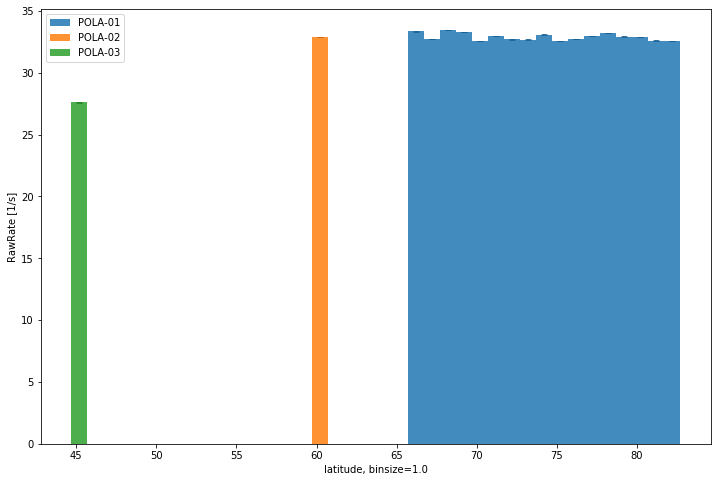

In [496]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs_with_cuts, "latitude", 1))

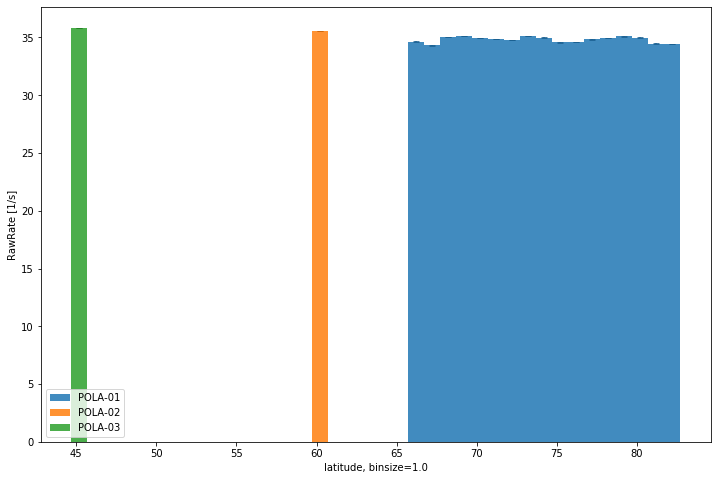

In [497]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs_corrected_pressure, "latitude", 1))